In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import pmdarima as pm
from matplotlib.pylab import rcParams
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
rcParams['figure.figsize'] =15, 6
import seaborn as sns
sns.set()


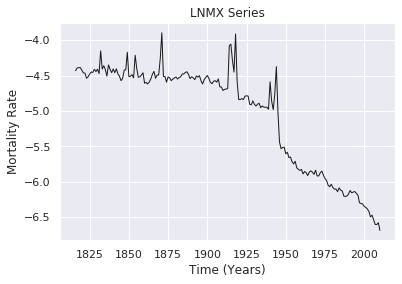

In [2]:
lnmx = pd.read_csv("lnmx_series.csv",index_col="Year")
lnmx = lnmx["40"]
lnmx = lnmx[lnmx.index<2011]

plt.plot(lnmx,linewidth=1,color="k")
plt.xlabel("Time (Years)")
plt.ylabel("Mortality Rate")
plt.title("LNMX Series")
plt.show()


In [3]:
split= 1990

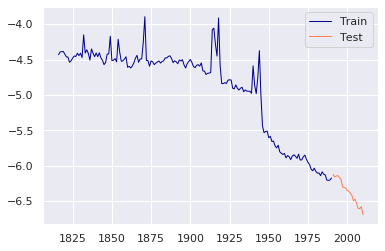

In [4]:
Train, Test = lnmx[lnmx.index<=split] ,lnmx[lnmx.index>split] # Train and Test series
plt.plot(Train,color="darkblue",linewidth=1,label="Train")
plt.plot(Test,color="coral",linewidth=1,label="Test")
plt.legend()
plt.show()

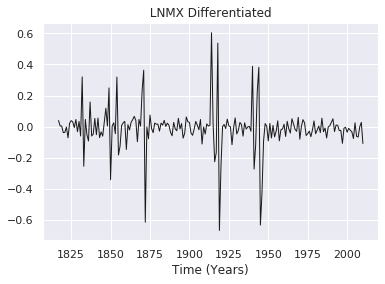

In [5]:
lnmx_diff = lnmx.diff().dropna()
plt.plot(lnmx_diff,c="k",linewidth=1)
plt.xlabel("Time (Years)")
plt.title(" LNMX Differentiated ")
plt.show()

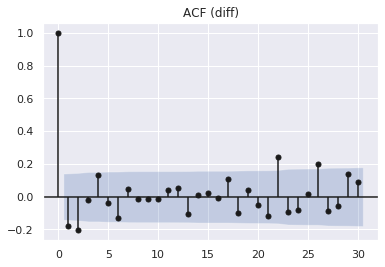

In [6]:
plot_acf(lnmx_diff, lags=30, c="k")
plt.title("ACF (diff)")
plt.show()

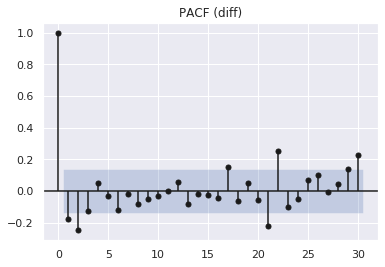

In [7]:
plot_pacf(lnmx_diff, lags=30, c= "k")
plt.title("PACF (diff)")
plt.show()

/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/home/ggcarvalho/anaconda3/lib/python3.7/site-packages/stats

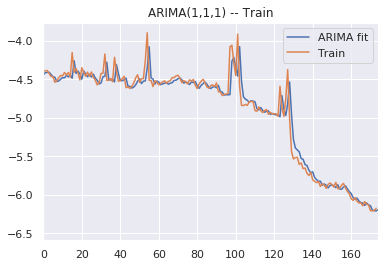

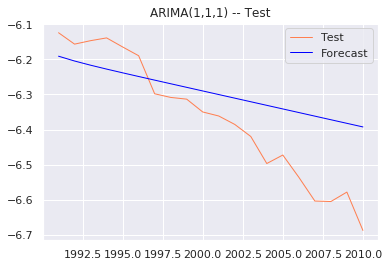

MSE ARIMA Train (diff. serie)=  0.018956761558202452
MSE ARIMA Test=  0.01866294590450137


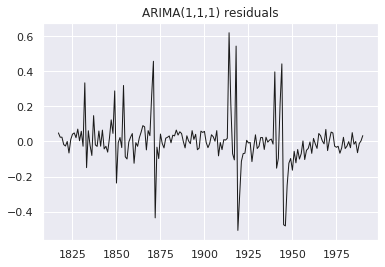

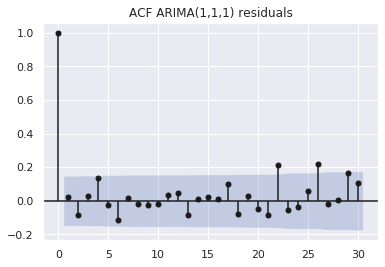

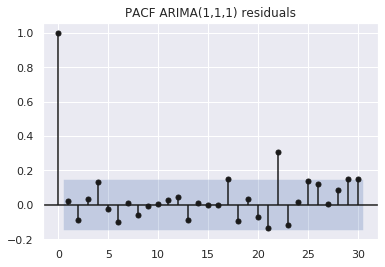

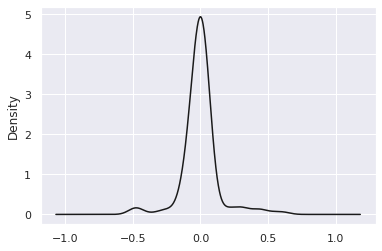

                0
count  174.000000
mean     0.000275
std      0.138081
min     -0.507001
25%     -0.040193
50%     -0.002874
75%      0.037690
max      0.619916


In [8]:
model = ARIMA(Train, order=(1, 1, 1))
fitted = model.fit(disp=0)
# Forecast
fc, se, conf = fitted.forecast(len(Test), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=Test.index)
arima_fittedValues = fitted.fittedvalues
# Plot
fitted.plot_predict(dynamic=False,start=1,end=len(Train))
plt.title("ARIMA(1,1,1) -- Train")
plt.legend(['ARIMA fit', 'Train' ])
plt.show()


plt.plot(Test,label="Test",color="coral",linewidth=1)
plt.plot(fc_series, label='Forecast',color="blue",linewidth=1)
plt.title("ARIMA(1,1,1) -- Test")
L=plt.legend(loc='best')
L.get_texts()[0].set_text('Test')
L.get_texts()[1].set_text('Forecast')
plt.show()


# MSE
mse_arima_train = mean_squared_error(lnmx_diff[lnmx_diff.index<=split], arima_fittedValues)
print("MSE ARIMA Train (diff. serie)= ", mse_arima_train)
mse_arima = mean_squared_error(Test, fc_series)
print("MSE ARIMA Test= ", mse_arima)
#print(fitted.summary())
#plot residual errors
residuals = pd.DataFrame(fitted.resid)
plt.plot(residuals,color='k',linewidth=1)
plt.title("ARIMA(1,1,1) residuals")
plt.show()
plot_acf(residuals,color="k",lags=30)
plt.title("ACF ARIMA(1,1,1) residuals")
plt.show()
plot_pacf(residuals,color="k",lags=30)
plt.title("PACF ARIMA(1,1,1) residuals")
plt.show()
residuals.plot(kind='kde',color='k').get_legend().remove()
plt.show()
print(residuals.describe())

In [13]:
serie = lnmx


In [14]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela

    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))

    for i in range(1, tam_serie-tam_janela):
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))

        janelas_np = np.vstack((janelas_np, j_np))


    return janelas_np

In [15]:
def diferenciar_serie(serie):
    #serie: obj pandas
    return serie.diff().dropna()


def incrementar_serie(serie_real, serie_diff):
    return serie_real[0:-1] + serie_diff

In [16]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]

    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)

    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x

    lags_selecionados = []

    for i in range(1, max_lag+1):


        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0

    #caso nenhum lag seja selecionado, essa atividade de seleção
    # para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

def split_serie_with_lags(serie, perc_train, perc_val = 0):

    #faz corte na serie com as janelas já formadas

    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]

    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)

    if perc_val > 0:
        val_size = np.fix(len(serie) *perc_val).astype(int)


        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )

        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]

        print("Particao de Validacao:",train_size, train_size+val_size)

        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]

        print("Particao de Teste:", train_size+val_size, len(y_date))

        return x_train, y_train, x_test, y_test, x_val, y_val

    else:

        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [17]:
tam_janela = 2
serie_janelas = gerar_janelas(tam_janela, serie)
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(serie_janelas, 0.6,
 perc_val = 0.297435897)

Particao de Treinamento: 0 115
Particao de Validacao: 115 172
Particao de Teste: 172 192


In [25]:
def treinar_mlp(x_train, y_train, x_val, y_val,num_exec):


    neuronios =  [1,2,3,5,10]  #[1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 150, 170, 200]
    func_activation =  ['tanh','relu']#['tanh']   #['identity', 'tanh', 'relu']
    alg_treinamento = ['lbfgs','adam','sgd']#, 'sgd', 'adam']
    max_iteracoes = [10000] #[100, 1000, 10000]
    learning_rate = ['constant','adaptive']  #['constant', 'invscaling', 'adaptive']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for j in range(0,len(func_activation)):
            for l in range(0,len(alg_treinamento)):
                for m in range(0,len(max_iteracoes)):
                    for n in range(0,len(learning_rate)):
                        for qtd_lag in range(1, len(x_train[0])+1):
                        #variar a qtd de pontos utilizados na janela

                            print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i],
                             'Func. Act', func_activation[j])


                            for e in range(0,num_exec):
                                mlp = MLPRegressor(hidden_layer_sizes=neuronios[i],
                                 activation=func_activation[j], solver=alg_treinamento[l],
                                  max_iter = max_iteracoes[m], learning_rate= learning_rate[n])


                                mlp.fit(x_train[:,-qtd_lag:], y_train)
                                predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                                mse = MSE(y_val, predict_validation)

                                if mse < best_result:
                                    best_result = mse
                                    print('Melhor MSE:', best_result)
                                    select_model = mlp
                                    qtd_lags_sel = qtd_lag


    return select_model, qtd_lags_sel

In [26]:
modelo, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val,10)

QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 1.4906085951777275
Melhor MSE: 0.6115452987197826
Melhor MSE: 0.5989197830407043
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.5961163516642808
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
Melhor MSE: 0.16752504206651792
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act tanh
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act relu
Melhor MSE: 0.15819445000631993
Melhor MSE: 0.15809416531289863
QTD de Lags: 1 Qtd de Neuronios 1 Func. Act relu
QTD de Lags: 2 Qtd de Neuronios 1 Func. Act r

In [27]:
predict_train = modelo.predict(x_train[:, -lag_sel:])
predict_val = modelo.predict(x_val[:, -lag_sel:])
predict_test = modelo.predict(x_test[:, -lag_sel:])

previsoes_train = np.hstack(( predict_train, predict_val))
target_train = np.hstack((y_train, y_val))

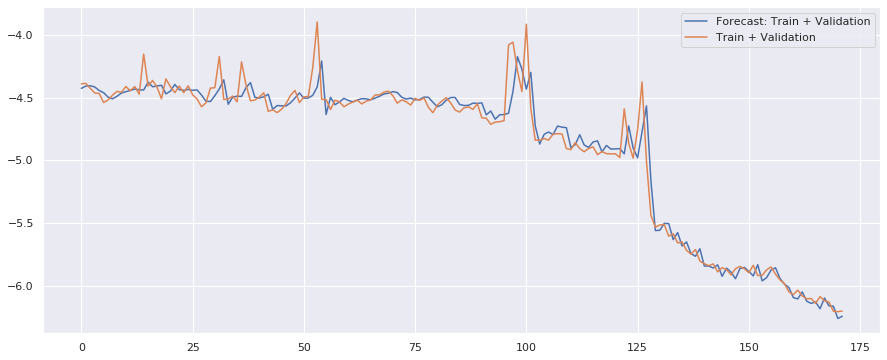

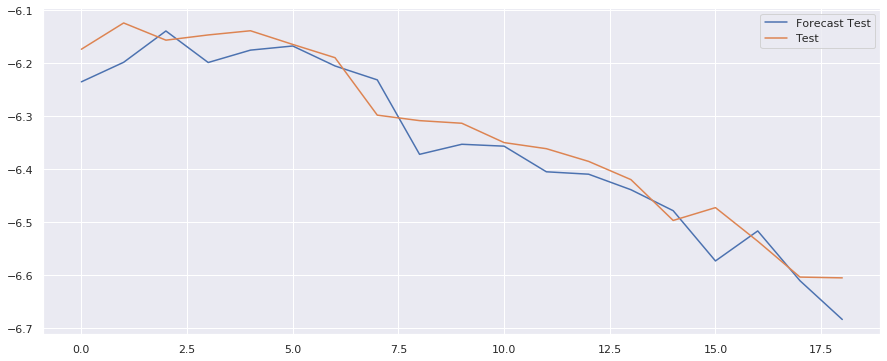

MSE treinamento = 0.015143200158090453
MSE Teste = 0.002314722554952271
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=3, learning_rate='adaptive',
             learning_rate_init=0.001, max_iter=10000, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)


In [28]:
plt.plot(previsoes_train, label = 'Forecast: Train + Validation')
plt.plot(target_train, label='Train + Validation')
plt.legend(loc='best')
plt.show()

plt.plot(predict_test, label = 'Forecast Test')
plt.plot(y_test, label='Test')
plt.legend(loc='best')
plt.show()

print("MSE treinamento = %s" %MSE(previsoes_train,target_train))
print("MSE Teste = %s" %MSE(y_test, predict_test))
print(modelo)